# MA3J8 Approximation Theory and Applications

## 05 - Least Squares Methods

In this notebooks we will explore in a little more detail how to fit functions using least squares fitting instead of interpolation. This is closer to the Hilbert-space setting, i.e., best approximation by projection.

First we implement some auxiliary functions: evaluating the chebyshev basis functions as well as a polynomial represented in terms of those basis functions.

In [1]:
using Plots, Polynomials, QuadGK, SoftGlobalScope, LinearAlgebra, LaTeXStrings, Plots
gr()

Plots.GRBackend()

In [2]:
function _pfitqr_(f, X, N, evalbasis)
    M = length(X)
    A = zeros(M, N+1)
    Y = f.(X)
    for m = 1:M
        A[m, :] = evalbasis(X[m], N)
    end 
    return qr(A) \ Y
end

function _pfitnormal_(f, X, N, evalbasis)
    M = length(X)
    A = zeros(M, N+1)
    Y = f.(X)
    for m = 1:M
        A[m, :] = evalbasis(X[m], N)
    end 
    return (A'*A) \ (A'*Y)
end


eval_monobasis(x, N) = [x^n for n = 0:N]

function eval_chebbasis(x::S, N) where {S}
    @assert N >= 2 
    T = zeros(S, N+1)
    T[1] = one(S)
    T[2] = x 
    for n = 2:N 
        T[n+1] = 2*x*T[n] - T[n-1]
    end 
    return T 
end

monofitn(f, X, N) = _pfitnormal_(f, X, N, eval_monobasis)
chebfitn(f, X, N) = _pfitnormal_(f, X, N, eval_chebbasis)

monofit(f, X, N) = _pfitqr_(f, X, N, eval_monobasis)
chebfit(f, X, N) = _pfitqr_(f, X, N, eval_chebbasis)

# this is not an efficient implementation since it 
# unnecessarily allocates a large array, but it is 
# brief and easy to read and will serve our purpose
eval_chebpoly(x, c) = dot(c, eval_chebbasis(x, length(c)-1))
eval_monopoly(x, c) = dot(c, eval_monobasis(x, length(c)-1))

eval_monopoly (generic function with 1 method)

### 05 - 1 Motivation / Fit via QR Factorisation

We begin by recalling a naive result from our polynomial approximation tests, where we experimented using least squares in place of (equi-spaced) polynomial interpolation. But this time, let's use our own code and also push the polynomial degree a bit higher!

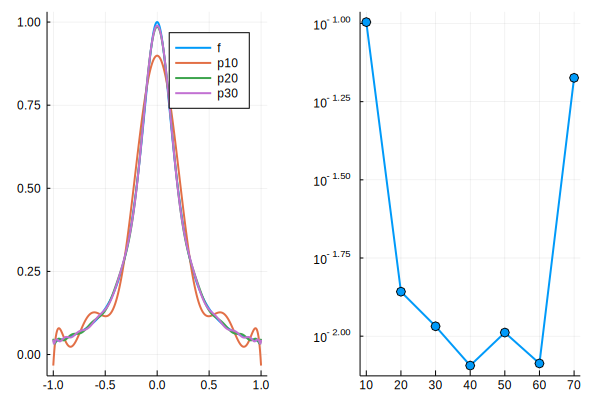

In [3]:
f(x) = 1 / (1 + 25 * x^2)
xp = range(-1, 1, length=400)
P = plot(xp, f.(xp), lw=2, label = "f")
err = []
NN = 10:10:70
for N in NN
    c = monofitn(f, xp, N)
    pc = [ eval_monopoly(x, c) for x in xp ]
    push!(err, norm(f.(xp) - pc, Inf))
    
    if N <= 30; plot!(P, xp, pc, lw=2, label = "p$N"); end 
end 
plot(P, plot(NN, err, lw=2, m=:o, yaxis = (:log,), label = ""), layout = (1,2))

We observe that around $N = 40$ even $M = 400$ datapoints are not enough to produce a stable / accurate fit?

But before we draw conclusions, let us attempt the same using the Chebyshev basis => this looks much more promising!

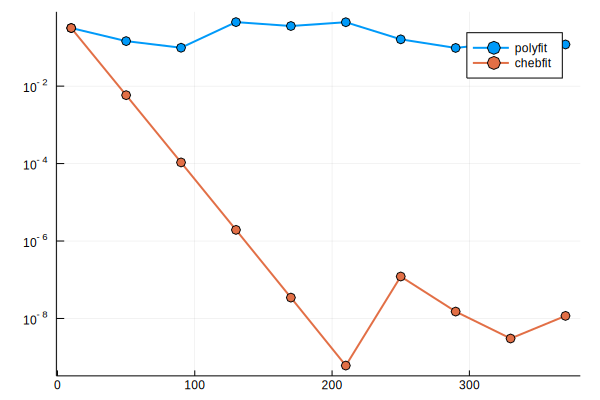

In [4]:
f(x) = 1 / (1 + 100 * x^2)
xp = range(-1, 1, length=1200)
err = []
errmono = [] 
errcheb = []
NN = 10:40:400
for N in NN
    c = monofitn(f, xp, N)
    pc = [ eval_monopoly(x, c) for x in xp ]
    push!(err, norm(f.(xp) - pc, Inf))

    c = chebfitn(f, xp, N)
    pc = [ eval_chebpoly(x, c) for x in xp ]
    push!(errcheb, norm(f.(xp) - pc, Inf))
end 
plot(NN, err, lw=2, m=:o, yaxis = (:log,), label = "polyfit")
plot!(NN, errcheb, lw=2, m=:o, label = "chebfit")

It is of course well-known that the normal equations are often ill-conditioned. We should use the QR factorisatoin instead (see code above).

So let's stress test it further: we compare fit with monomials, and chebyshev basis, using the normal equations or QR to solve the least squares system - and on a more difficult example.

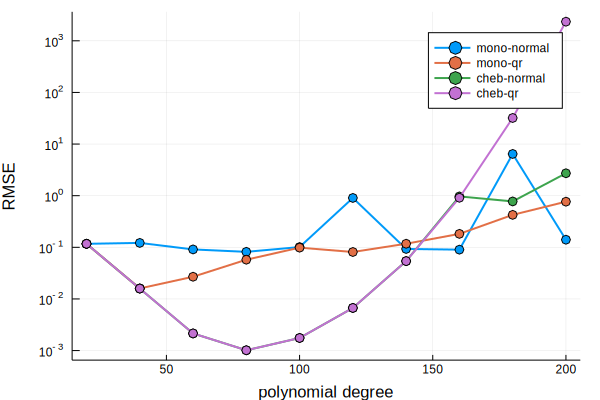

In [9]:
# easy parameters 
# C, Mfit, NN = 25, 600, 19:20:200
# medium parameters 
C, Mfit, NN = 100, 600, 20:20:200
# harder parameters 
# C, Mfit, NN = 400, 1000, 20:60:500

f(x) = 1 / (1 + C * x^2)
xp = range(-1, 1, length=Mfit)
xe = range(-1, 1, length=4*Mfit)
errmono, errmonon, errcheb, errchebn = [], [], [], []
for N in NN
    c = monofitn(f, xp, N)
    pc = [ eval_monopoly(x, c) for x in xe ]
    push!(errmonon, norm(f.(xe) - pc, Inf))

    c = monofit(f, xp, N)
    pc = [ eval_monopoly(x, c) for x in xe ]
    push!(errmono, norm(f.(xe) - pc, Inf))

    c = chebfitn(f, xp, N)
    pc = [ eval_chebpoly(x, c) for x in xe ]
    push!(errchebn, norm(f.(xe) - pc, Inf))

    c = chebfit(f, xp, N)
    pc = [ eval_chebpoly(x, c) for x in xe ]
    push!(errcheb, norm(f.(xe) - pc, Inf))
end 
plot(; yaxis = (:log, "RMSE"), xaxis = ("polynomial degree",))
plot!(NN, errmonon, lw=2, m=:o, label = "mono-normal")
plot!(NN, errmono, lw=2, m=:o, label = "mono-qr")
plot!(NN, errchebn, lw=2, m=:o, label = "cheb-normal")
plot!(NN, errcheb, lw=2, m=:o, label = "cheb-qr")
# hline!([1e-16])

### 05-2 Fitting with Weights 

In the previous section we did something that is possibly a bit odd. We used a Chebyshev basis to fit polynomials with datapoints $x_m$ uniformaly distributed in $[-1,1]$ whereas Chebyshev polynomials are orthogonal w.r.t the measure $(1-x^2)^{-1/2} dx$. It therefore seems natural to (1) either incorporate the Chebyshev weights 
$$
w_m = (1 - x_m^2)^{-1/2}
$$
into the fitting process; or (2) to fit on Chebyshev-distributed data points.
$$
x_m = \cos\big(\pi m/M\big)
$$
We will next explore the consequences of this modification.

In [10]:
struct ChebPoly{T}
    c::Vector{T}
end
(p::ChebPoly)(x) = eval_chebpoly(x, p.c)

function chebfit1(f, N, M, data=:unif, weights=:unif)
    if data == :unif
        X = range(-1, 1, length=M)
    elseif data == :cheb
        X = cos.(range(0, pi, length=M))
    else
        error("Unknown `data`")
    end
    
    if weights == :unif
        W = ones(length(X))
    elseif weights == :cheb  # W<-√W
        W = (1+1e-10 .- X.^2).^(-0.25) 
    else 
        error("Unknown `weights`")
    end
        
    
    Y = f.(X)
    A = zeros(M, N+1)
    for m = 1:M
        A[m, :] = eval_chebbasis(X[m], N)
    end
    
    # apply weights
    Y = W .* Y 
    A = Diagonal(W) * A 
   
    p = ChebPoly(qr(A) \ Y)
    return p, norm(W .* p.(X) - Y) / norm(Y)
end 
   

chebfit1 (generic function with 3 methods)

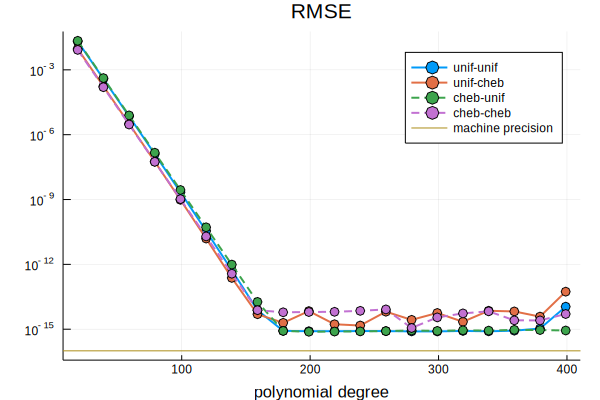

In [12]:
# easy parameters 
C, Mfit, NN = 25, 400, 19:20:399
# medium parameters 
# C, Mfit, NN = 100, 400, 20:20:380
# harder parameters 
# C, Mfit, NN = 400, 1000, 20:60:980

f(x) = 1 / (1 + C * x^2)
err_uu, err_uc, err_cu, err_cc = [], [], [], []
for N in NN
    push!(err_uu, chebfit1(f, N, Mfit, :unif, :unif)[2])
    push!(err_uc, chebfit1(f, N, Mfit, :unif, :cheb)[2])
    push!(err_cu, chebfit1(f, N, Mfit, :cheb, :unif)[2])
    push!(err_cc, chebfit1(f, N, Mfit, :cheb, :cheb)[2])
end 
plot(; yaxis = (:log, ), xaxis = ("polynomial degree",), title = "RMSE")
plot!(NN, err_uu, lw=2, m=:o, label = "unif-unif")
plot!(NN, err_uc, lw=2, m=:o, label = "unif-cheb")
plot!(NN, err_cu, lw=2, ls=:dash, m=:o, label = "cheb-unif")
plot!(NN, err_cc, lw=2, ls=:dash, m=:o, label = "cheb-cheb")
P_rmse = hline!([1e-16], label = "machine precision")

But the RMSE on the training set is misleading! We should consider the RMSE on a second Test Set! 

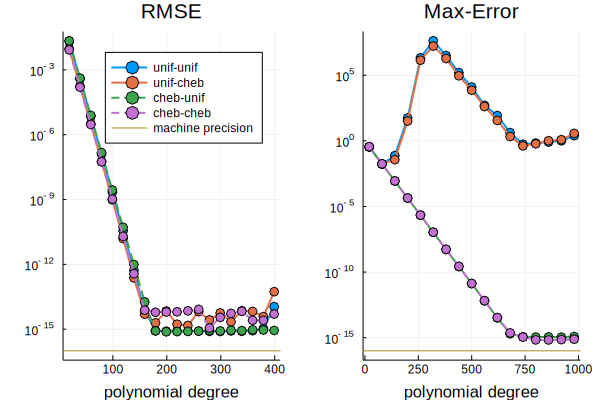

In [15]:
# easy parameters 
# C, Mfit, NN = 25, 400, 19:20:399
# medium parameters 
# C, Mfit, NN = 100, 400, 20:20:380
# harder parameters 
C, Mfit, NN = 400, 1000, 20:60:980

xe = cos.(range(0, pi, length=4000))
f(x) = 1 / (1 + C * x^2)
err_uu_inf, err_uc_inf, err_cu_inf, err_cc_inf = [], [], [], []
for N in NN
    push!(err_uu_inf, norm(f.(xe) - chebfit1(f, N, Mfit, :unif, :unif)[1].(xe), Inf))
    push!(err_uc_inf, norm(f.(xe) - chebfit1(f, N, Mfit, :unif, :cheb)[1].(xe), Inf))
    push!(err_cu_inf, norm(f.(xe) - chebfit1(f, N, Mfit, :cheb, :unif)[1].(xe), Inf))
    push!(err_cc_inf, norm(f.(xe) - chebfit1(f, N, Mfit, :cheb, :cheb)[1].(xe), Inf))
end 
plot(; yaxis = (:log, ), xaxis = ("polynomial degree",), title = "Max-Error")        
plot!(NN, err_uu_inf, lw=2, m=:o, label = "")
plot!(NN, err_uc_inf, lw=2, m=:o, label = "")
plot!(NN, err_cu_inf, lw=2, m=:o, label = "")
plot!(NN, err_cc_inf, lw=2, ls=:dash, m=:o, label = "")
P_maxe = hline!([1e-16], label = "")
plot(P_rmse, P_maxe)

### 05-3 Fit at Random Points 

The most realistic real-world context is that we cannot choose the data-points but are given - likely random - datapoints. The first step should then be to construct an orthogonal basis adapted to the distribution of the points. Since we work mostly with Chebyshev here we assume that the distribution is the Chebyshev distribution. 

In [16]:
function chebfit2(f, N, M, data=:unif, weights=:unif; 
                  xe = cos.(range(0,pi, length=M*5)))
    if data == :unif
        X = range(-1, 1, length=M)
    elseif data == :cheb
        X = cos.(range(0, pi, length=M))
    elseif data == :rand
        X = 2*(rand(M) .- 0.5)
    elseif data == :randcheb
        X = cos.(pi * rand(M))
    else
        error("Unknown `data`")
    end
    
    if weights == :unif
        W = ones(length(X))
        we = ones(length(xe))
    elseif weights == :cheb  # W<-√W
        W = (1+1e-10 .- X.^2).^(-0.25)
        we = (1+1e-10 .- xe.^2).^(-0.25)
    else
        error("Unknown `weights`")
    end
    
    Y = f.(X)
    A = zeros(M, N+1)
    for m = 1:M
        A[m, :] = eval_chebbasis(X[m], N)
    end
    
    # apply weights
    Y = W .* Y 
    A = Diagonal(W) * A 
   
    p = ChebPoly(qr(A) \ Y)
    rmse = norm(W .* p.(X) - Y) / norm(Y)
    rmse_fine = norm(we .* (p.(xe) - f.(xe)), Inf) / norm(we .* f.(xe))
    return p, rmse, rmse_fine
end 
   

chebfit2 (generic function with 3 methods)

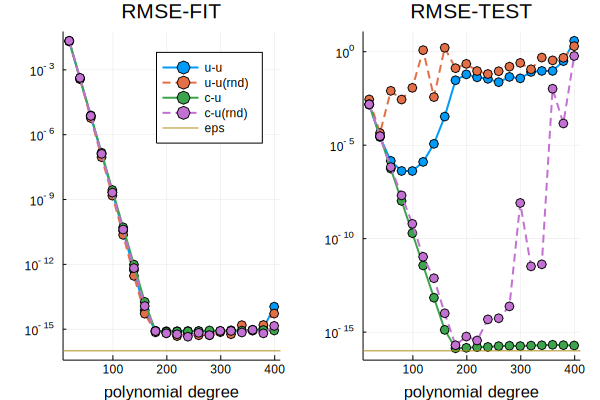

In [17]:
# easy parameters 
C, Mfit, NN = 25, 400, 19:20:399
# medium parameters 
# C, Mfit, NN = 100, 400, 20:20:380
# harder parameters 
# C, Mfit, NN = 400, 981, 20:60:980


f(x) = 1 / (1 + C * x^2)
err_uu, err_ru, err_cu, err_rcu = [], [], [], []
err_uu_inf, err_ru_inf, err_cu_inf, err_rcu_inf = [], [], [], []
for N in NN
    _, rmse, rmse_fine = chebfit2(f, N, Mfit, :unif)
    push!(err_uu, rmse); push!(err_uu_inf, rmse_fine)
    _, rmse, rmse_fine = chebfit2(f, N, Mfit, :rand)
    push!(err_ru, rmse); push!(err_ru_inf, rmse_fine)
    _, rmse, rmse_fine = chebfit2(f, N, Mfit, :cheb)
    push!(err_cu, rmse); push!(err_cu_inf, rmse_fine)
    _, rmse, rmse_fine = chebfit2(f, N, Mfit, :randcheb)
    push!(err_rcu, rmse); push!(err_rcu_inf, rmse_fine)
end 

plot(; yaxis = (:log,), xaxis = ("polynomial degree",), title="RMSE-FIT")
plot!(NN, err_uu, lw=2, m=:o, label = "u-u")
plot!(NN, err_ru, lw=2, ls=:dash, m=:o, label = "u-u(rnd)")
plot!(NN, err_cu, lw=2, m=:o, label = "c-u")
plot!(NN, err_rcu, lw=2, ls=:dash, m=:o, label = "c-u(rnd)")
P_rmse = hline!([1e-16], label = "eps")

plot(; yaxis = (:log,), xaxis = ("polynomial degree",), title="RMSE-TEST")
plot!(NN, err_uu_inf, lw=2, m=:o, label = "")
plot!(NN, err_ru_inf, lw=2, ls=:dash, m=:o, label = "")
plot!(NN, err_cu_inf, lw=2, m=:o, label = "")
plot!(NN, err_rcu_inf, lw=2, ls=:dash, m=:o, label = "")
P_maxe = hline!([1e-16], label = "")

plot(P_rmse, P_maxe)

The analysis of [Cohen, Davenport, Leviatan, 2012] suggests that we should turn the problem around: given a number of data-points $M$ we should then choose an appropriate degree $N$. In practise it seems best to combine theory with experimentation. 

Here, we learn that we need $N$ slightly smaller than $M$ (a log-factor is suggested in the paper) to ensure that the LSQ system is stable (moderate condition number) with high probability. The additional error that arises is 
$$
  M^{-r}
$$
where $M$ is the number of data points and $r$ is given by a complicated relation, but for the Chebyshev basis with random points $x_m$ distributed according to the Chebyshev distribtion we have $r \approx C M / N$. To balance the errors we want $r \log M \approx \alpha N$, i.e., $C M/N \approx C \log M$, or, $N \approx C M/\log M$. The $C$ is a bit difficult to determine analytically, so we do it experimentally.

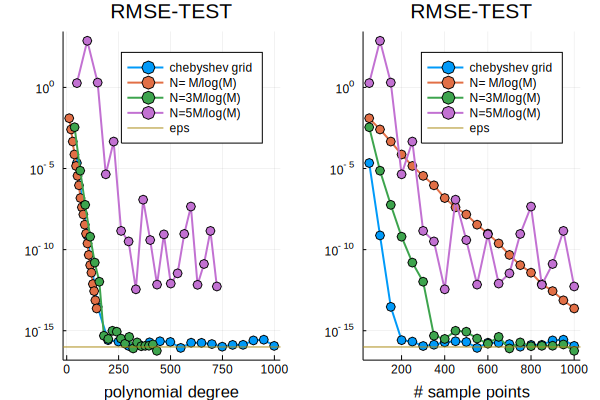

In [22]:
C, MM = 25, 50:50:1000
f(x) = 1 / (1 + C * x^2)

Nfun(M, Nsugg) = floor(Int, min(M-1, Nsugg))
N1(M) = Nfun(M, M / log(M))
N2(M) = Nfun(M, 3*M/log(M))
N3(M) = Nfun(M, 5*M/log(M))

err, err1, err2, err3 = [], [], [], []
for M in MM
    push!(err,  chebfit2(f, M-1, M, :cheb)[3])
    push!(err1, chebfit2(f, N1(M), M, :randcheb)[3])
    push!(err2, chebfit2(f, N2(M), M, :randcheb)[3])
    push!(err3, chebfit2(f, N3(M), M, :randcheb)[3])
end 

plot(; yaxis = (:log,), xaxis = ("polynomial degree",), title="RMSE-TEST")
plot!(MM.-1, err, lw=2, m=:o, label = "chebyshev grid")
plot!(N1.(MM), err1, lw=2, m=:o, label = "N= M/log(M)")
plot!(N2.(MM), err2, lw=2, m=:o, label = "N=3M/log(M)")
plot!(N3.(MM), err3, lw=2, m=:o, label = "N=5M/log(M)")
PN = hline!([1e-16], label = "eps")

plot(; yaxis = (:log,), xaxis = ("# sample points",), title="RMSE-TEST")
plot!(MM, err, lw=2, m=:o, label = "chebyshev grid")
plot!(MM, err1, lw=2, m=:o, label = "N= M/log(M)")
plot!(MM, err2, lw=2, m=:o, label = "N=3M/log(M)")
plot!(MM, err3, lw=2, m=:o, label = "N=5M/log(M)")
PM = hline!([1e-16], label = "eps")

plot(PN, PM)